# GenAI ED Ops Copilot – Data & Model Integration Notebook

**Author:** Kanishk Tawde  
**Course:** Advances in Data Science & Architecture  
**Project:** GenAI ED Ops Copilot – A Generative AI–Driven Decision Support System for Emergency Department Demand Forecasting

---

## Notebook Overview

This notebook implements the core data and modeling pipeline for the GenAI ED Ops Copilot:

1. **Data Collection & Preparation**
   - Generate or load daily Emergency Department (ED) visit data
   - Clean and validate the time series
   - Perform exploratory data analysis (EDA)
   - Create train–test splits for forecasting

2. **Time Series Modeling**
   - Fit a SARIMAX/ARIMA model to the ED demand series
   - Evaluate forecasting performance on a hold-out period
   - Generate future forecasts with confidence intervals

3. **Model Integration with Generative AI**
   - Summarize historical patterns, forecast results, and metrics
   - Build context strings suitable for a Large Language Model (LLM)
   - Integrate with the OpenAI API to:
     - Generate natural-language explanations of the forecasts
     - Support Q&A about the ED demand patterns

This notebook serves as the analytical backbone for the final Streamlit application.


In [26]:
!pip install mistralai python-dotenv

   ---------------------------------------- 0.0/442.8 kB ? eta -:--:--
   ----------------- ---------------------- 194.6/442.8 kB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 442.8/442.8 kB 5.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/160.3 kB ? eta -:--:--
   ---------------------------------------- 160.3/160.3 kB 9.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/158.8 kB ? eta -:--:--
   ---------------------------------------- 158.8/158.8 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0.1
    Uninstalling PyYAML-6.0.1:
      Successfully uninstalled PyYAML-6.0.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.75 requires requests_mock, which is not installed.
conda-repo-cli 1.0.75 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.75 requires PyYAML==6.0.1, but you have pyyaml 6.0.3 which is incompatible.
conda-repo-cli 1.0.75 requires requests==2.31.0, but you have requests 2.32.5 which is incompatible.
notebook 7.0.8 requires jupyterlab<4.1,>=4.0.2, but you have jupyterlab 4.3.5 which is incompatible.


### SETUP: Imports and Configuration

In [28]:
# ============================================================
# SETUP: Imports and Configuration
# ============================================================


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

from mistralai import Mistral
from dotenv import load_dotenv

# Set some plotting defaults
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

load_dotenv()

MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")

if MISTRAL_API_KEY is None:
    print("⚠️ MISTRAL_API_KEY not found. LLM calls will be skipped.")
    mistral_client = None
else:
    mistral_client = Mistral(api_key=MISTRAL_API_KEY)


### Data Collection and Preparation

In this section, we:

1. **Identify the dataset**  
   - For this project, we use daily ED visit counts (synthetic or de-identified).

2. **Generate or load the data**
    - If a real dataset is not available, we generate synthetic ED data that mimics:
     - A base ED volume level
     - Weekly seasonality (weekday vs weekend)
     - Random noise
     - Optional mild annual/seasonal effects

3. **Clean and preprocess the data**
   - Parse dates
   - Ensure proper data types
   - Handle missing or invalid values
   - Enforce one row per date
   - Set a daily time index

This produces a clean, well-structured time series ready for forecasting and for feeding derived summaries into the Generative AI layer.


In [6]:
# ============================================================
# Configuration: Choose Data Source
# ============================================================

USE_SYNTHETIC_DATA = True  # Set to False if you want to load your own CSV
DATA_PATH = "data/ed_visits_sample.csv"  # Path where synthetic data will be stored/loaded

os.makedirs("data", exist_ok=True)


In [7]:
# ============================================================
# Synthetic Data Generation
# ============================================================

def generate_synthetic_ed_data(
    start_date="2022-01-01",
    end_date="2024-12-31",
    base_level=120,
    weekday_uplift=15,
    weekend_drop=-20,
    seasonal_amplitude=10,
    noise_std=8,
    random_seed=42,
) -> pd.DataFrame:
    """
    Generate synthetic daily ED visit data with:
    - Baseline volume
    - Weekly seasonality (weekday vs weekend)
    - Mild annual seasonality
    - Random noise
    
    Returns a DataFrame with columns: ['date', 'visits'].
    """
    rng = np.random.default_rng(random_seed)
    dates = pd.date_range(start=start_date, end=end_date, freq="D")
    n = len(dates)
    
    # Base signal
    visits = np.full(shape=n, fill_value=base_level, dtype=float)
    
    # Weekly pattern: Mon-Fri higher, Sat-Sun lower
    dow = dates.dayofweek  # Monday=0, Sunday=6
    weekday_mask = dow < 5
    weekend_mask = dow >= 5
    
    visits[weekday_mask] += weekday_uplift
    visits[weekend_mask] += weekend_drop
    
    # Mild annual seasonality: sine wave over the year
    day_of_year = dates.dayofyear
    seasonal_effect = seasonal_amplitude * np.sin(2 * np.pi * day_of_year / 365.25)
    visits += seasonal_effect
    
    # Random noise
    noise = rng.normal(loc=0.0, scale=noise_std, size=n)
    visits += noise
    
    # Enforce non-negative and round to realistic integer counts
    visits = np.maximum(visits, 0)
    visits = np.round(visits).astype(int)
    
    df = pd.DataFrame({
        "date": dates,
        "visits": visits
    })
    return df

# Generate and save synthetic data if using synthetic mode
if USE_SYNTHETIC_DATA:
    df_synth = generate_synthetic_ed_data()
    df_synth.to_csv(DATA_PATH, index=False)
    print(f"Synthetic ED data generated and saved to: {DATA_PATH}")
    df_synth.head()


Synthetic ED data generated and saved to: data/ed_visits_sample.csv


In [8]:
# ============================================================
# Data Loading and Initial Cleaning
# ============================================================

def load_ed_data(path: str) -> pd.DataFrame:
    """
    Load ED daily visits data from a CSV file.
    
    Expected columns:
      - 'date': parseable as datetime
      - 'visits': daily ED visit count (numeric)
    """
    df = pd.read_csv(path)
    
    # Parse date column
    if "date" not in df.columns:
        raise ValueError("Input CSV must contain a 'date' column.")
        
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    
    # Coerce 'visits' to numeric
    if "visits" not in df.columns:
        raise ValueError("Input CSV must contain a 'visits' column.")
        
    df["visits"] = pd.to_numeric(df["visits"], errors="coerce")
    
    # Drop rows with missing date or visits
    df = df.dropna(subset=["date", "visits"])
    
    # Sort and set index
    df = df.sort_values("date").set_index("date")
    
    # Ensure integer counts
    df["visits"] = df["visits"].astype(int)
    
    return df

df = load_ed_data(DATA_PATH)
print("Loaded ED dataset shape:", df.shape)
df.head()


Loaded ED dataset shape: (1096, 1)


,visits
date,
2022-01-01,103
2022-01-02,92
2022-01-03,142
2022-01-04,143
2022-01-05,120


### Data Validation and Frequency Check

We now:

- Check for missing values  
- Check for duplicate dates  
- Enforce a daily frequency index  
- Optionally handle missing dates if they appear


In [9]:
# ============================================================
# Data Validation and Frequency Enforcement
# ============================================================

# Basic info
print(df.info())
print("\nMissing values per column:\n", df.isna().sum())

# Check for duplicate dates
duplicates = df.index.duplicated().sum()
print(f"\nNumber of duplicate dates: {duplicates}")

if duplicates > 0:
    # If duplicates exist, we could aggregate them. For now, we sum visits.
    df = df.groupby(df.index).agg({"visits": "sum"})
    print("Duplicates found and aggregated by summing visits per date.")

# Enforce a daily frequency (D)
df = df.asfreq("D")

# If any new NaNs arise from missing dates, we can fill them.
missing_after_freq = df["visits"].isna().sum()
print(f"\nMissing values after enforcing daily frequency: {missing_after_freq}")

if missing_after_freq > 0:
    # For this prototype, forward-fill then back-fill if at start of series.
    df["visits"] = df["visits"].ffill().bfill()
    print("Missing visits after frequency enforcement filled via ffill/bfill.")

print("\nFinal dataset shape after cleaning and frequency enforcement:", df.shape)
df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2022-01-01 to 2024-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   visits  1096 non-null   int32
dtypes: int32(1)
memory usage: 12.8 KB
None

Missing values per column:
 visits    0
dtype: int64

Number of duplicate dates: 0

Missing values after enforcing daily frequency: 0

Final dataset shape after cleaning and frequency enforcement: (1096, 1)


,visits
date,
2022-01-01,103
2022-01-02,92
2022-01-03,142
2022-01-04,143
2022-01-05,120


### Exploratory Data Analysis (EDA)

We now explore the ED visits time series to understand:

- Typical levels (mean, min, max)
- Overall variability
- Temporal patterns (trend and seasonality)
- Day-of-week effects

This EDA also justifies using a model with weekly seasonality (period = 7 days).


In [10]:
# ============================================================
# Summary Statistics
# ============================================================

summary_stats = df["visits"].describe()
print(summary_stats)


count    1096.000000
mean      124.782847
std        18.873584
min        76.000000
25%       111.000000
50%       129.000000
75%       140.000000
max       169.000000
Name: visits, dtype: float64


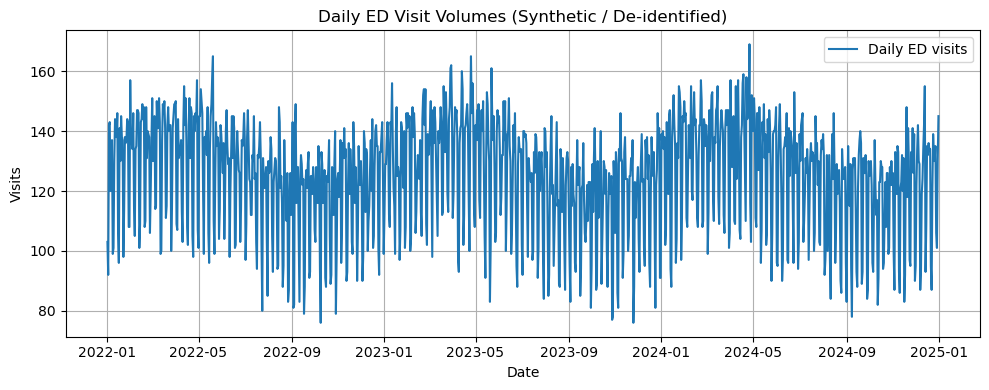

In [11]:
# ============================================================
# Time Series Plot
# ============================================================

plt.figure()
plt.plot(df.index, df["visits"], label="Daily ED visits")
plt.title("Daily ED Visit Volumes (Synthetic / De-identified)")
plt.xlabel("Date")
plt.ylabel("Visits")
plt.legend()
plt.tight_layout()
plt.show()


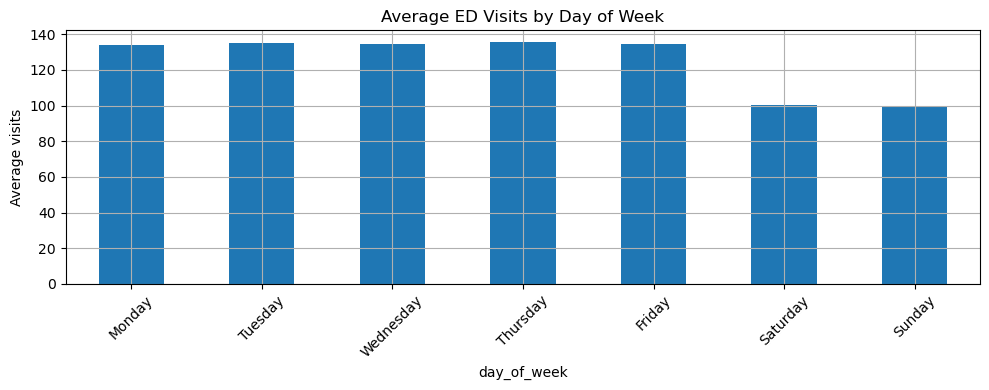

day_of_week
Monday       134.191083
Tuesday      135.089172
Wednesday    134.423077
Thursday     135.410256
Friday       134.416667
Saturday     100.191083
Sunday        99.949045
Name: visits, dtype: float64

In [12]:
# ============================================================
# Day-of-Week Analysis
# ============================================================

# Add a day-of-week column temporarily for analysis
df_dow = df.copy()
df_dow["day_of_week"] = df_dow.index.day_name()

dow_means = df_dow.groupby("day_of_week")["visits"].mean().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

plt.figure()
dow_means.plot(kind="bar")
plt.title("Average ED Visits by Day of Week")
plt.ylabel("Average visits")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

dow_means


### Time Series Modeling for ED Demand Forecasting

In this section, we:

1. Create a train–test split to evaluate the forecasting model.  
2. Fit a SARIMAX/ARIMA model with weekly seasonality.  
3. Evaluate the model using standard error metrics:
   - MAE (Mean Absolute Error)
   - RMSE (Root Mean Squared Error)
   - MAPE (Mean Absolute Percentage Error)
4. Generate future forecasts (e.g., 30 days ahead) with confidence intervals.


In [13]:
# ============================================================
# Train–Test Split
# ============================================================

TEST_DAYS = 30  # hold-out period for evaluation

train = df.iloc[:-TEST_DAYS].copy()
test = df.iloc[-TEST_DAYS:].copy()

print("Train period:", train.index.min().date(), "to", train.index.max().date())
print("Test period :", test.index.min().date(), "to", test.index.max().date())
print("Train shape:", train.shape, "| Test shape:", test.shape)


Train period: 2022-01-01 to 2024-12-01
Test period : 2024-12-02 to 2024-12-31
Train shape: (1066, 1) | Test shape: (30, 1)


In [14]:
# ============================================================
# Fit SARIMAX Model
# ============================================================

def fit_sarimax_model(
    train_series: pd.Series,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7)
):
    """
    Fit a SARIMAX model to the training series with weekly seasonality.
    
    Parameters:
    - train_series: pd.Series of daily ED visits (indexed by date)
    - order: ARIMA(p,d,q) parameters
    - seasonal_order: Seasonal (P,D,Q,s) parameters, with s=7 for weekly seasonality
    
    Returns:
    - fitted_model: statsmodels SARIMAXResults object
    """
    model = SARIMAX(
        train_series,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    fitted = model.fit(disp=False)
    return fitted

sarimax_model = fit_sarimax_model(train["visits"])
print(sarimax_model.summary())


                                     SARIMAX Results                                     
Dep. Variable:                            visits   No. Observations:                 1066
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3706.733
Date:                           Sat, 06 Dec 2025   AIC                           7423.465
Time:                                   18:57:41   BIC                           7448.243
Sample:                               01-01-2022   HQIC                          7432.860
                                    - 12-01-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0710      0.034      2.095      0.036       0.005       0.138
ma.L1         -0.9149      0.014    -65.062

In [15]:
# ============================================================
# Forecast on the Test Period and Evaluate
# ============================================================

# Forecast for the length of the test set
test_forecast_res = sarimax_model.get_forecast(steps=TEST_DAYS)
test_pred_mean = test_forecast_res.predicted_mean
test_conf_int = test_forecast_res.conf_int(alpha=0.05)

# Align index with test set
test_pred_mean.index = test.index
test_conf_int.index = test.index

# Evaluation metrics
def evaluate_forecast(y_true: pd.Series, y_pred: pd.Series):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

metrics = evaluate_forecast(test["visits"], test_pred_mean)
metrics


{'MAE': 6.601702739148908,
 'RMSE': 8.560535187471313,
 'MAPE': 5.313566442594622}

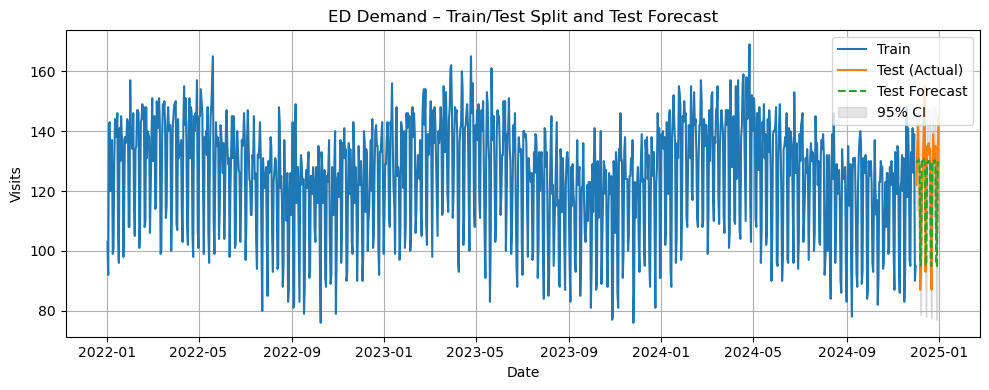

In [16]:
# ============================================================
# Actual vs Predicted on Test Period
# ============================================================

plt.figure()
plt.plot(train.index, train["visits"], label="Train")
plt.plot(test.index, test["visits"], label="Test (Actual)")
plt.plot(test_pred_mean.index, test_pred_mean.values, label="Test Forecast", linestyle="--")
plt.fill_between(
    test_conf_int.index,
    test_conf_int.iloc[:, 0],
    test_conf_int.iloc[:, 1],
    color="gray",
    alpha=0.2,
    label="95% CI",
)
plt.title("ED Demand – Train/Test Split and Test Forecast")
plt.xlabel("Date")
plt.ylabel("Visits")
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
# ============================================================
# Future Forecast (e.g., next 30 days)
# ============================================================

FORECAST_DAYS = 30

future_forecast_res = sarimax_model.get_forecast(steps=FORECAST_DAYS)
future_mean = future_forecast_res.predicted_mean
future_conf = future_forecast_res.conf_int(alpha=0.05)

# Create a date index for future period
last_date = df.index.max()
future_index = pd.date_range(start=last_date + pd.Timedelta(days=1),
                             periods=FORECAST_DAYS, freq="D")

future_mean.index = future_index
future_conf.index = future_index

df_future = pd.DataFrame({
    "forecast": future_mean,
    "lower_ci": future_conf.iloc[:, 0],
    "upper_ci": future_conf.iloc[:, 1],
})

df_future.head()


,forecast,lower_ci,upper_ci
2025-01-01,129.605143,113.575676,145.634609
2025-01-02,130.119389,113.895585,146.343192
2025-01-03,129.782045,113.485074,146.079017
2025-01-04,130.496736,114.133211,146.860261
2025-01-05,129.602696,113.173302,146.032090


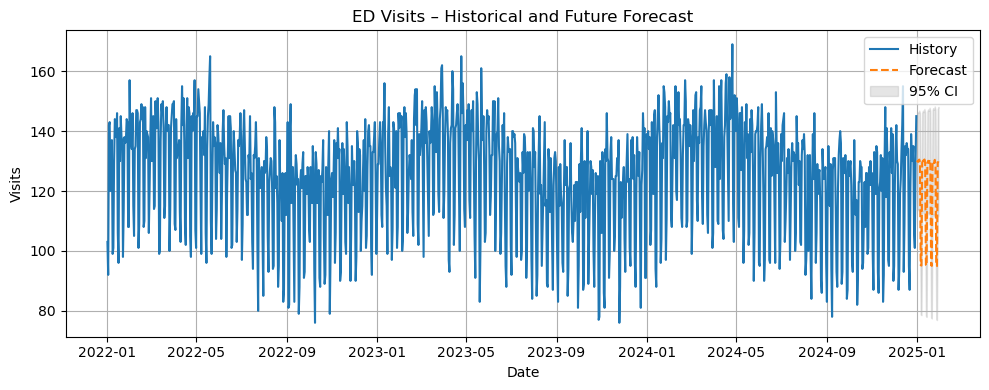

In [18]:
# ============================================================
# Plot: Historical + Future Forecast
# ============================================================

plt.figure()
plt.plot(df.index, df["visits"], label="History")
plt.plot(df_future.index, df_future["forecast"], label="Forecast", linestyle="--")
plt.fill_between(
    df_future.index,
    df_future["lower_ci"],
    df_future["upper_ci"],
    color="gray",
    alpha=0.2,
    label="95% CI",
)
plt.title("ED Visits – Historical and Future Forecast")
plt.xlabel("Date")
plt.ylabel("Visits")
plt.legend()
plt.tight_layout()
plt.show()


## 4. Preparing Data and Model Outputs for Generative AI

The Generative AI modelMistral AIPT) doe**n** work directly on raw numeric time series.  
Instead, we:

1. Compute **summary statistics** and **performance metrics**.  
2. Create short, human-readable **text summaries** of:
   - Historical ED patterns  
   - Forecasted ED patterns  
3. Package these into a **context string** that the LLM can use to:
   - Generate explanations  
   - Answer ED operations questions  
ations questions  


In [19]:
# ============================================================
# Build Summary Descriptions for LLM Context
# ============================================================

def build_history_summary(df: pd.DataFrame) -> str:
    """
    Create a short textual summary of historical ED visit patterns.
    """
    start = df.index.min().date()
    end = df.index.max().date()
    avg_visits = df["visits"].mean()
    min_visits = df["visits"].min()
    max_visits = df["visits"].max()
    
    dow_means = df.groupby(df.index.day_name())["visits"].mean()
    busiest_day = dow_means.idxHighest = dow_means.idxmax()
    quietest_day = dow_means.idxmin()
    
    summary = (
        f"Historical ED data covers the period from {start} to {end}. "
        f"Average daily visits are approximately {avg_visits:.1f}, "
        f"with a minimum of {min_visits} and a maximum of {max_visits}. "
        f"On average, the busiest day of the week is {busiest_day}, "
        f"while the quietest day is {quietest_day}. "
        f"There appears to be a clear weekly pattern, with "
        f"weekday volumes generally higher than weekends."
    )
    return summary

def build_forecast_summary(df_future: pd.DataFrame) -> str:
    """
    Create a short textual summary of forecasted ED patterns.
    """
    start = df_future.index.min().date()
    end = df_future.index.max().date()
    avg_forecast = df_future["forecast"].mean()
    min_forecast = df_future["forecast"].min()
    max_forecast = df_future["forecast"].max()
    
    summary = (
        f"The forecast covers the period from {start} to {end}. "
        f"Average predicted daily ED visits are around {avg_forecast:.1f}, "
        f"with forecasted values ranging from {min_forecast:.0f} to {max_forecast:.0f}. "
        f"Confidence intervals widen slightly further into the future, "
        f"indicating increasing uncertainty over time."
    )
    return summary

history_summary = build_history_summary(df)
forecast_summary = build_forecast_summary(df_future)

metrics_summary = (
    f"On the held-out test period, the forecasting model achieved "
    f"a Mean Absolute Error (MAE) of {metrics['MAE']:.2f}, "
    f"a Root Mean Squared Error (RMSE) of {metrics['RMSE']:.2f}, "
    f"and a Mean Absolute Percentage Error (MAPE) of {metrics['MAPE']:.2f}%. "
    f"This indicates that, on average, the model's predictions are within "
    f"approximately {metrics['MAPE']:.1f}% of the true daily ED visit counts."
)

print("=== Historical Summary ===")
print(history_summary)
print("\n=== Forecast Summary ===")
print(forecast_summary)
print("\n=== Metrics Summary ===")
print(metrics_summary)


=== Historical Summary ===
Historical ED data covers the period from 2022-01-01 to 2024-12-31. Average daily visits are approximately 124.8, with a minimum of 76 and a maximum of 169. On average, the busiest day of the week is Thursday, while the quietest day is Sunday. There appears to be a clear weekly pattern, with weekday volumes generally higher than weekends.

=== Forecast Summary ===
The forecast covers the period from 2025-01-01 to 2025-01-30. Average predicted daily ED visits are around 120.5, with forecasted values ranging from 95 to 131. Confidence intervals widen slightly further into the future, indicating increasing uncertainty over time.

=== Metrics Summary ===
On the held-out test period, the forecasting model achieved a Mean Absolute Error (MAE) of 6.60, a Root Mean Squared Error (RMSE) of 8.56, and a Mean Absolute Percentage Error (MAPE) of 5.31%. This indicates that, on average, the model's predictions are within approximately 5.3% of the true daily ED visit counts.

In [20]:
# ============================================================
# Build LLM Context String
# ============================================================

def build_llm_context(history_text: str, forecast_text: str, metrics_text: str) -> str:
    """
    Combine the different textual components into a single context string
    for the Generative AI model.
    """
    context = (
        "Emergency Department (ED) Demand Forecasting Context\n"
        "----------------------------------------------------\n\n"
        "Historical Pattern Summary:\n"
        f"{history_text}\n\n"
        "Forecast Summary:\n"
        f"{forecast_text}\n\n"
        "Model Performance Summary:\n"
        f"{metrics_text}\n\n"
        "Use this information to explain the ED demand patterns and forecasts "
        "to a non-technical hospital operations manager. "
        "Focus on trends, patterns, uncertainty, and operational implications "
        "such as staffing and capacity planning."
    )
    return context

llm_context = build_llm_context(history_summary, forecast_summary, metrics_summary)
print(llm_context[:1000], "...")


Emergency Department (ED) Demand Forecasting Context
----------------------------------------------------

Historical Pattern Summary:
Historical ED data covers the period from 2022-01-01 to 2024-12-31. Average daily visits are approximately 124.8, with a minimum of 76 and a maximum of 169. On average, the busiest day of the week is Thursday, while the quietest day is Sunday. There appears to be a clear weekly pattern, with weekday volumes generally higher than weekends.

Forecast Summary:
The forecast covers the period from 2025-01-01 to 2025-01-30. Average predicted daily ED visits are around 120.5, with forecasted values ranging from 95 to 131. Confidence intervals widen slightly further into the future, indicating increasing uncertainty over time.

Model Performance Summary:
On the held-out test period, the forecasting model achieved a Mean Absolute Error (MAE) of 6.60, a Root Mean Squared Error (RMSE) of 8.56, and a Mean Absolute Percentage Error (MAPE) of 5.31%. This indicates th

### Generative AI Model Integration (Mistral AI)

We now **integrate a Generative AI model** to:

1. Produce a **natural-language explanation** of the ED historical and forecasted demand.  
2. Answer **free-form questions** from an ED manager about the forecast.

### Model Choice

- We use the **Mistral AI model family** through the `mistralai` Python SDK.  
- A reasonable starting model for explanations is:  
  - **`mistral-small-latest`** (fast and cost-effective), or  
  - **`mistral-medium-latest`** / **`mistral-large-latest`** if higher reasoning capability is required.

We configure the model via:

- A **system message** that sets the role: “ED operations analyst / consultant.”  
- A **user message** that includes our `llm_context`.  
- Optional **temperature** tuning for more/less creativity.  


In [33]:
def generate_ed_explanation(context_text: str, model="mistral-small-latest") -> str:
    if mistral_client is None:
        return "Mistral API key missing. Cannot generate explanation."

    response = mistral_client.chat.complete(
        model=model,
        messages=[
            {
                "role": "system",
                "content": (
                    "You are a healthcare operations analyst explaining ED demand forecasts "
                    "to non-technical hospital managers. Avoid technical jargon."
                ),
            },
            {
                "role": "user",
                "content": (
                    "Use the context to explain the ED forecasting results clearly:\n\n"
                    + context_text
                ),
            },
        ],
    )

    # 🔧 FIX IS HERE:
    return response.choices[0].message.content


In [35]:
def answer_manager_question(question: str, context_text: str, model="mistral-small-latest") -> str:
    """
    Use the Mistral LLM to answer a manager's question about ED demand,
    grounded in the provided context (history, forecast, metrics).
    """
    if mistral_client is None:
        return "Mistral API key missing. Cannot answer the question."

    response = mistral_client.chat.complete(
        model=model,
        messages=[
            {
                "role": "system",
                "content": (
                    "You are an Emergency Department operations consultant. "
                    "Use ONLY the provided context (historical patterns, forecasts, and metrics) "
                    "to answer questions. If the context does not support a detailed answer, "
                    "say so clearly. Avoid making up facts."
                ),
            },
            {
                "role": "user",
                "content": (
                    f"Context:\n{context_text}\n\n"
                    f"Manager's question: {question}"
                ),
            },
        ],
    )

    # 🔧 Use attribute access, not dict-style
    return response.choices[0].message.content


In [34]:
# ============================================================
# 5.2 Generate Explanation
# ============================================================

# ============================================================
# 5.2 Generate Explanation
# ============================================================

if mistral_client is None:
    print("⚠️ Skipping LLM call because MISTRAL_API_KEY is not set.")
else:
    explanation_text = generate_ed_explanation(llm_context)
    print("=== LLM-Generated Explanation ===\n")
    print(explanation_text)



=== LLM-Generated Explanation ===

Sure, let's break down the information in a way that's easy to understand and focus on what it means for your hospital's operations.

**Past Patterns (2022-2024):**

1. **Daily Visits:** On average, our Emergency Department (ED) sees about 125 patients each day. However, this number can vary significantly, from as low as 76 to as high as 169 patients in a day.

2. **Weekly Pattern:** We've noticed a clear pattern where weekdays (Monday to Friday) are generally busier than weekends (Saturday and Sunday). Specifically, Thursdays tend to be the busiest day of the week, while Sundays are usually the quietest.

**Future Forecast (January 2025):**

1. **Expected Visits:** For the first month of 2025, we anticipate seeing an average of about 120 patients each day. This is a slight decrease from our historical average, but it's important to note that this is just an estimate and the actual number can vary.

2. **Range of Predictions:** Our predictions suggest

In [36]:
# ============================================================
# Manager Q&A 
# ============================================================

if mistral_client is None:
    print("⚠️ Skipping LLM Q&A because MISTRAL_API_KEY is not set.")
else:
    sample_question = "Which days in the forecast period should we be most worried about for crowding and why?"
    answer_text = answer_manager_question(sample_question, llm_context)
    
    print("=== Manager's Question ===")
    print(sample_question)
    print("\n=== LLM's Answer ===\n")
    print(answer_text)


=== Manager's Question ===
Which days in the forecast period should we be most worried about for crowding and why?

=== LLM's Answer ===

Based on the provided context, here's how you should interpret the ED demand patterns and forecasts:

1. **Historical Patterns:**
   - On average, the ED receives about 124.8 visits per day.
   - Thursdays are typically the busiest days, while Sundays are the quietest.
   - Weekdays generally have higher volumes than weekends.

2. **Forecast for January 2025:**
   - The average predicted daily visits are slightly lower than the historical average, at around 120.5.
   - The forecasted daily visits range from 95 to 131, with increasing uncertainty as the month progresses.

3. **Days to be most worried about:**
   - Since Thursdays have historically been the busiest days, you should pay close attention to the Thursdays in the forecast period (January 2nd, 9th, 16th, 23rd, and 30th).
   - The forecast predicts that daily visits could reach up to 131, whi

### Summary

In this notebook, we:

1. **Collected and prepared data**  
   - Generated or loaded synthetic/de-identified daily ED visit counts  
   - Cleaned and validated the time series  
   - Performed basic EDA to understand patterns and justify weekly seasonality  

2. **Built a time series forecasting model**  
   - Used a SARIMAX model with weekly seasonality  
   - Evaluated performance on a hold-out test set  
   - Generated future forecasts with confidence intervals  

3. **Integrated a Generative AI model (Mistral AI)**  
   - Constructed rich, domain-specific context from model outputs  
   - Generated natural-language explanations for ED managers  
   - Implemented a Q&A function that answers free-form questions using the forecast context
